# Phishing URL Detection


From Wikipedia, https://en.wikipedia.org/wiki/Phishing

> Phishing is the fraudulent attempt to obtain sensitive information such as usernames, passwords and credit card details, often for malicious reasons, by disguising as a trustworthy entity in an electronic communication. The word is a neologism created as a homophone of fishing due to the similarity of using a bait in an attempt to catch a victim. The annual worldwide impact of phishing could be as high as US$5 billion.
>
> Phishing is typically carried out by email spoofing or instant messaging, and it often directs users to enter personal information at a fake website, the look and feel of which are identical to the legitimate site, the only difference being the URL of the website in concern. Communications purporting to be from social web sites, auction sites, banks, online payment processors or IT administrators are often used to lure victims. Phishing emails may contain links to websites that distribute malware.
>
> Phishing is an example of social engineering techniques used to deceive users, and it exploits weaknesses in current web security. Attempts to deal with the growing number of reported phishing incidents include legislation, user training, public awareness, and technical security measures.

Here's an example of a real phishing email sent in 2011 by attackers looking to get login credentials for Facebook users:

<pre>
LAST WARNING : Your account is reported to have violated the policies that are considered annoying or insulting Facebook users.

Until we system will disable your account within 24 hours if you do not do the reconfirmation.

Please confirm your account below:

[ Link Removed ]

Thanks.
The Facebook Team
Copyright facebook © 2011 Inc. All rights reserved.
</pre>

A victim clicking on the Phishing link would be taken to a site that looked like a pretty good copy of the Facebook login screen.

<img src="images/Not_Facebook.png">

Here are some examples of the links used in emails sent by the attackers running this phishing campaign:

**Note**: These links may be dangerous to your computer. Our practice will be to "neuter" links by wrapping certain characters with square brackets so that you cannot click on these links, or accidentally copy/paste them into your browser.

**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**
<pre>
http[:]//team-welcome[.]at[.]ua/facebook-support[.]html
http[:]//reportedpages[.]at[.]ua/facebook-support-account[.]html
http[:]//www[.]facebooks[.]cloud/PayPlls[.]CEanada[.]tNZnZZlR3ZdyZZ-5RkZZDRTZZBy
http[:]//www[.]greenaura[.]net/appz[.]westpac/westpac[.]appz/login[.]php
http[:]//www[.]irastrum[.]com/wp-admin/mail[.]yahoo[.]com/
http[:]//appleid[.]apple[.]com-subscriptions[.]manager508158125[.]kevinfoley[.]com
</pre>
**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**


Something smells a little phishy about these links. Given a close look by a human, you'd probably be able to decide pretty quickly if the link was really sent by Facebook or not. But billions of people get hundreds or thousands of emails each every day! How can defenders keep up with the onslaught by the phishers?

## The Problem

We want to use methods from Machine Learning to build a computer program that will automatically flag links it thinks are phishing attempts. We can do this by studying the problem, looking at data, and learning a decision rule.

The dataset we will be using is named "Phishing_Mitre_Dataset_Summer_of_AI.csv". 

#### Analyze the data, build features, or use the existing features in the data to build a model, and report your findings. We will use the F1 score to evaluate the final models using a test set that we have set aside. 

## Explore Some Data

Let's take a look at the provided features on our set of URLs. 

* Create Age (in Months): The age of the domain. If the value is -1, that information is not available or the domain has been deleted. 
* Expiry Age (in Months): The amount of months until the domain expires. If the value is negative, that information is not available or the domain has been deleted.
* Update Age (in Days): The last time the domain was updated. If the value is -1, that information is not available or the domain was deleted.
* URL: The URL of the website. Three periods have been added to the end of each URL to prevent the URL from being clicked for security purposes. 
* Label: A label to determine whether a website is a phishing link or not. 0 denotes a website that is not a phishing link, 1 denotes a website is a phishing link. 

# Approach Ideas

1) Load in data

2) EDA -- make graphs, print out statistics -- statistics of each field, % of 0's, length of URLs, number of symbols/alpha/numeric/special characters or weird symbols/ending thing "com" or "org"/http vs https

3) Research what goes into a malicious URL and try to leverage that in creating more features

4) Split the data into train, validation, test (never touch the test data)

5) perhaps re-encode URL as a one-hot code embedding?

# 1 Load in data

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'MITRE/Group2HackathonChallenge-main'

assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/MITRE/Group2HackathonChallenge-main


In [2]:
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn, skimage

In [3]:
filename = sys.path[-1] + "/training-data/Phishing_Mitre_Dataset_Summer_of_AI.csv"
print(filename)

/content/drive/My Drive/MITRE/Group2HackathonChallenge-main/training-data/Phishing_Mitre_Dataset_Summer_of_AI.csv


In [4]:
df = pandas.read_csv(filename)
df

,create_age(months),expiry_age(months),update_age(days),URL,Label
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1
1,212,16,663,http://www.coffeespecialties.com/...,0
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1
3,198,6,186,http://atomicsoda.com/manutd...,0
4,240,24,1684,http://bostoncoffeecake.com/...,0
...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1
4795,-1,-1,-1,http://www.mazda.co.jp/...,0
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1


# 2 Exploratory Data Analysis (EDA)

Note: 0 = not malicious/good, 1 = malicious/phishing/bad

Don't forget to cut off the three '...' at the end of each URL!

URL Features

1) Length

2) Number of Special Characters

3) Number of URL segments (split on "/")

4) Cut off "http://" 

5) Number of Numerical Digits

6) top level domain ".com", ".php", etc.

In [5]:
urls = df["URL"].values
https_count = 0
http_count = 0
both_count = 0
unaccounted = 0
for url in urls:
    if "https://" in url:
        if "http://" not in url:
            https_count += 1
        else:
            both_count += 1
    elif "http://" in url:
        http_count += 1
    else:
        unaccounted += 1

print("https count:", https_count)
print("http count:", http_count)
print("http and https count:", both_count)
print("unaccounted:", unaccounted)

print("https percentage:", 100*https_count/len(urls))

assert len(urls) == https_count + http_count + both_count + unaccounted

https count: 65
http count: 4733
http and https count: 1
unaccounted: 0
https percentage: 1.3544488435090645


In [6]:
# condition on HTTPS URLs
https_df = df.loc[df['URL'].str.slice(0, 8) == "https://"]
print("Conditioned on HTTPS URLs")

https_labels = https_df["Label"].values
print("Number of Malicious Labels:", sum(https_labels))
print("Number of Non-Malicious Labels:", len(https_df) - sum(https_labels))

print("% of Malicious Labels:", 100*sum(https_labels)/len(https_df))
print("% of Non-Malicious Labels:", 100*(len(https_df) - sum(https_labels))/len(https_df))

Conditioned on HTTPS URLs
Number of Malicious Labels: 42
Number of Non-Malicious Labels: 23
% of Malicious Labels: 64.61538461538461
% of Non-Malicious Labels: 35.38461538461539


In [7]:
# condition on HTTP URLs
http_df = df.loc[df['URL'].str.slice(0, 7) == "http://"]
print("Conditioned on HTTP URLs")

http_labels = http_df["Label"].values
print("Number of Malicious Labels:", sum(http_labels))
print("Number of Non-Malicious Labels:", len(http_df) - sum(http_labels))

print("% of Malicious Labels:", 100*sum(http_labels)/len(http_df))
print("% of Non-Malicious Labels:", 100*(len(http_df) - sum(http_labels))/len(http_df))

Conditioned on HTTP URLs
Number of Malicious Labels: 2513
Number of Non-Malicious Labels: 2221
% of Malicious Labels: 53.084072665821715
% of Non-Malicious Labels: 46.915927334178285


min length: 17
max length: 107


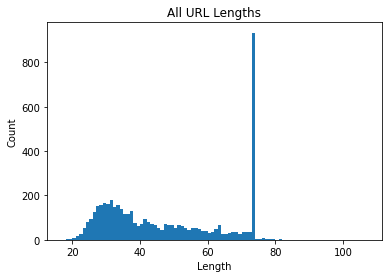

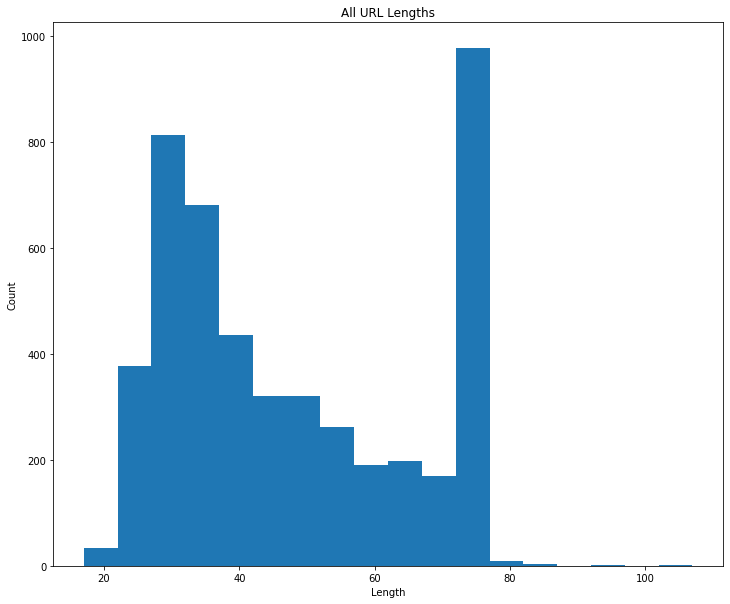

In [22]:
# visualize lengths of all URLs
url_lengths = []
for url in urls:
    url_lengths.append(len(url))

print("min length:", min(url_lengths))
print("max length:", max(url_lengths))

binwidth = 1
plt.hist(url_lengths, bins=range(min(url_lengths), max(url_lengths) + binwidth, binwidth))
plt.title("All URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()
binwidth = 5
plt.figure(figsize=(12,10))
plt.hist(url_lengths, bins=range(min(url_lengths), max(url_lengths) + binwidth, binwidth))
plt.title("All URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")

plt.show()

min length: 16
max length: 76
avg length: 55.32681017612524


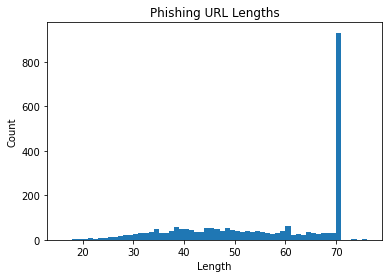

Text(0, 0.5, 'Count')

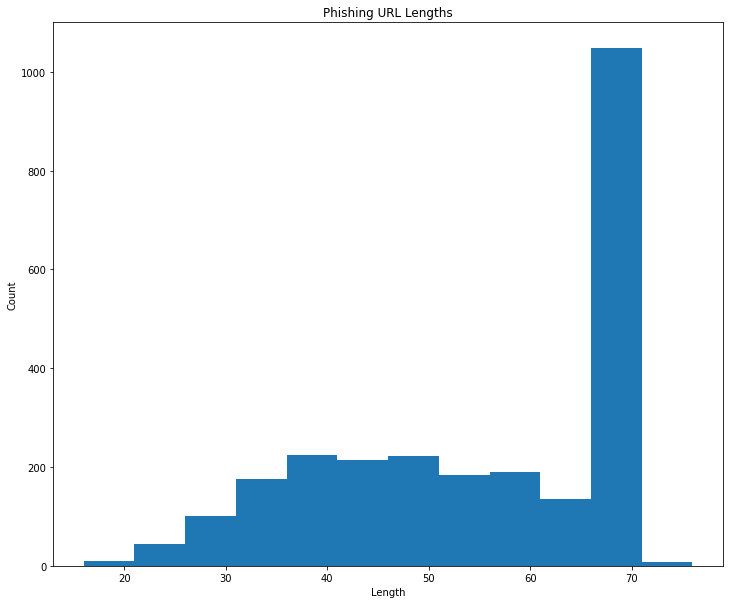

In [23]:
# A look at malicious URL lengths
mal_df = df.loc[df['Label'] == 1]
mal_urls = mal_df['URL'].values

mal_url_lengths = []
for url in mal_urls:
    url = url[:-3]
    mal_url_lengths.append(len(url))

print("min length:", min(mal_url_lengths))
print("max length:", max(mal_url_lengths))
print("avg length:", sum(mal_url_lengths)/len(mal_url_lengths))

binwidth = 1
plt.hist(mal_url_lengths, bins=range(min(mal_url_lengths), max(mal_url_lengths) + binwidth, binwidth))
plt.title("Phishing URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()
binwidth = 5
plt.figure(figsize=(12,10))
plt.hist(mal_url_lengths, bins=range(min(mal_url_lengths), max(mal_url_lengths) + binwidth, binwidth))
plt.title("Phishing URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")

min length: 14
max length: 104
avg length: 31.18048128342246


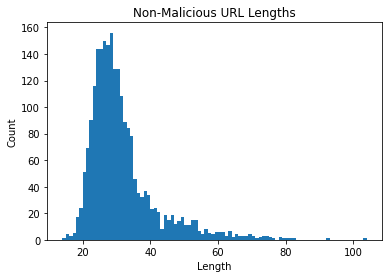

Text(0, 0.5, 'Count')

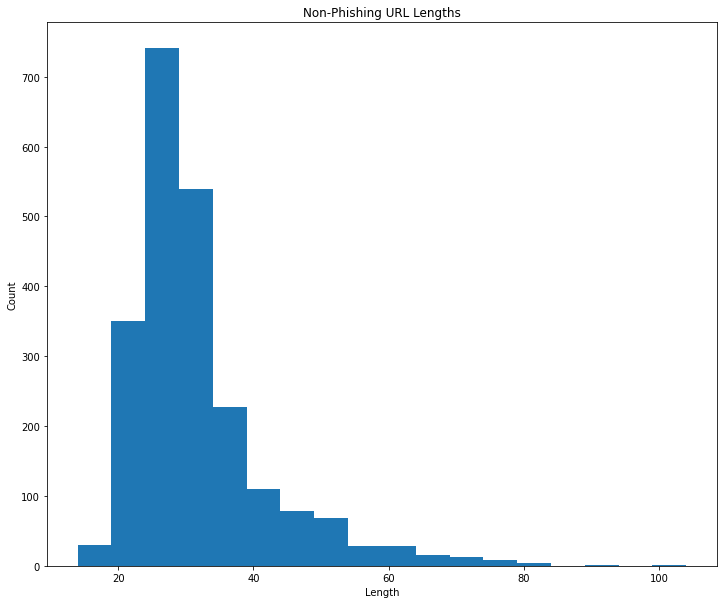

In [61]:
# A look at non-malicious URL lengths
good_df = df.loc[df['Label'] == 0]
good_urls = good_df['URL'].values

good_url_lengths = []
for url in good_urls:
    url = url[:-3]
    good_url_lengths.append(len(url))

print("min length:", min(good_url_lengths))
print("max length:", max(good_url_lengths))
print("avg length:", sum(good_url_lengths)/len(good_url_lengths))

binwidth = 1
plt.hist(good_url_lengths, bins=range(min(good_url_lengths), max(good_url_lengths) + binwidth, binwidth))
plt.title("Non-Malicious URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()
binwidth = 5
plt.figure(figsize=(12,10))
plt.hist(good_url_lengths, bins=range(min(good_url_lengths), max(good_url_lengths) + binwidth, binwidth))
plt.title("Non-Phishing URL Lengths")
plt.xlabel("Length")
plt.ylabel("Count")

In [62]:
def get_char_counts(url):
    numbers = sum(c.isdigit() for c in url)
    letters = sum(c.isalpha() for c in url)
    spaces  = sum(c.isspace() for c in url)
    others  = len(url) - numbers - letters - spaces
    return numbers, letters, spaces, others

For all URLs...
...the average count of numerical digits: 2.509272765159408
...the average count of letters: 33.429256095019795
...the average count of others: 8.097520316732652


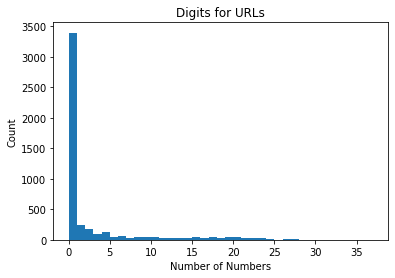

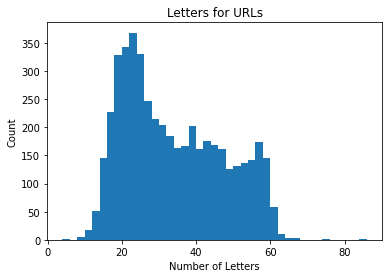

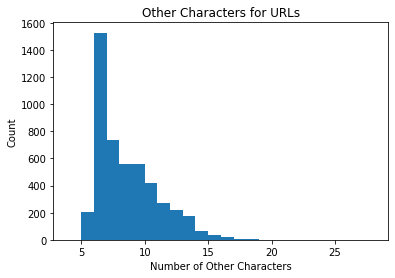

In [69]:
# for all URLs, inspecting character types/numerical breakdown
numbers = []
letters = []
spaces = []
others = []

for url in urls:
    url = url[:-3]
    n, l, s, o = get_char_counts(url)
    numbers.append(n)
    letters.append(l)
    spaces.append(s)
    others.append(o)

print("For all URLs...")
print("...the average count of numerical digits:", sum(numbers)/len(urls))
print("...the average count of letters:", sum(letters)/len(urls))
# print("...the average count of spaces:", sum(spaces)/len(urls))
print("...the average count of others:", sum(others)/len(urls))

binwidth = 1
plt.hist(numbers, bins=range(min(numbers), max(numbers) + binwidth, binwidth))
plt.title("Digits for URLs")
plt.xlabel("Number of Digits")
plt.ylabel("Count")
plt.show()

binwidth = 2
plt.hist(letters, bins=range(min(letters), max(letters) + binwidth, binwidth))
plt.title("Letters for URLs")
plt.xlabel("Number of Letters")
plt.ylabel("Count")
plt.show()

binwidth = 1
plt.hist(others, bins=range(min(others), max(others) + binwidth, binwidth))
plt.title("Other Characters for URLs")
plt.xlabel("Number of Other Characters")
plt.ylabel("Count")
plt.show()

For a non-phishing URL...
...the average count of numerical digits: 0.08981037716190873
...the average count of letters: 11.356115857470307
...the average count of others: 3.13398624713482


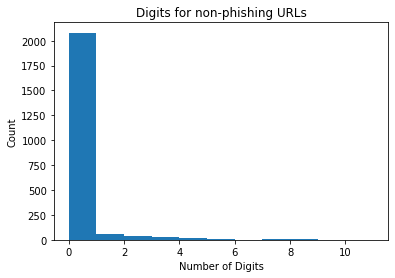

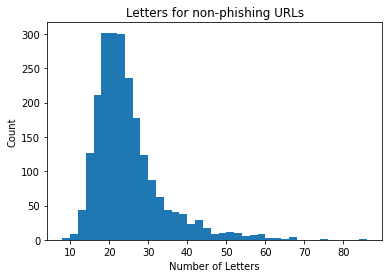

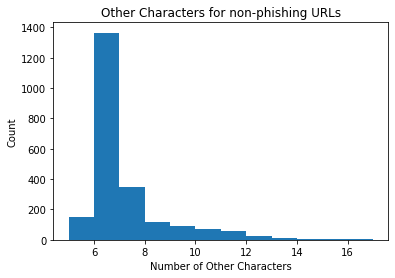

In [70]:
# for good/non-malicious URLs, inspecting character types/numerical breakdown
numbers = []
letters = []
spaces = []
others = []

for url in good_urls:
    url = url[:-3]
    n, l, s, o = get_char_counts(url)
    numbers.append(n)
    letters.append(l)
    spaces.append(s)
    others.append(o)

print("For a non-phishing URL...")
print("...the average count of numerical digits:", sum(numbers)/len(urls))
print("...the average count of letters:", sum(letters)/len(urls))
# print("...the average count of spaces:", sum(spaces)/len(urls))
print("...the average count of others:", sum(others)/len(urls))

binwidth = 1
plt.hist(numbers, bins=range(min(numbers), max(numbers) + binwidth, binwidth))
plt.title("Digits for non-phishing URLs")
plt.xlabel("Number of Digits")
plt.ylabel("Count")
plt.show()

binwidth = 2
plt.hist(letters, bins=range(min(letters), max(letters) + binwidth, binwidth))
plt.title("Letters for non-phishing URLs")
plt.xlabel("Number of Letters")
plt.ylabel("Count")
plt.show()

binwidth = 1
plt.hist(others, bins=range(min(others), max(others) + binwidth, binwidth))
plt.title("Other Characters for non-phishing URLs")
plt.xlabel("Number of Other Characters")
plt.ylabel("Count")
plt.show()

For a phishing URL...
...the average count of numerical digits: 2.4194623879974997
...the average count of letters: 22.073140237549488
...the average count of others: 4.9635340695978325


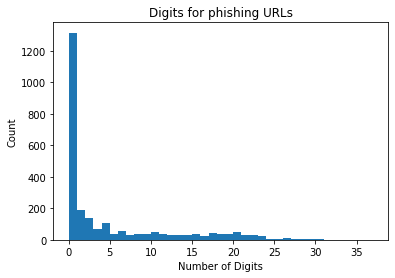

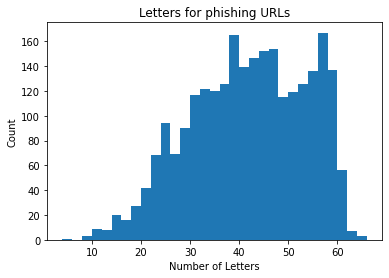

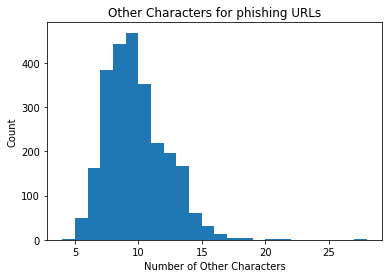

In [71]:
# for phishing/malicious URLs, inspecting character types/numerical breakdown
numbers = []
letters = []
spaces = []
others = []

for url in mal_urls:
    url = url[:-3]
    n, l, s, o = get_char_counts(url)
    numbers.append(n)
    letters.append(l)
    spaces.append(s)
    others.append(o)

print("For a phishing URL...")
print("...the average count of numerical digits:", sum(numbers)/len(urls))
print("...the average count of letters:", sum(letters)/len(urls))
# print("...the average count of spaces:", sum(spaces)/len(urls))
print("...the average count of others:", sum(others)/len(urls))

binwidth = 1
plt.hist(numbers, bins=range(min(numbers), max(numbers) + binwidth, binwidth))
plt.title("Digits for phishing URLs")
plt.xlabel("Number of Digits")
plt.ylabel("Count")
plt.show()

binwidth = 2
plt.hist(letters, bins=range(min(letters), max(letters) + binwidth, binwidth))
plt.title("Letters for phishing URLs")
plt.xlabel("Number of Letters")
plt.ylabel("Count")
plt.show()

binwidth = 1
plt.hist(others, bins=range(min(others), max(others) + binwidth, binwidth))
plt.title("Other Characters for phishing URLs")
plt.xlabel("Number of Other Characters")
plt.ylabel("Count")
plt.show()

In [116]:
# Looking at domains for all URLs

domains = []
for url in urls:
    url = url[:-3]
    blocks = url.split('/') # split by '/'
    words = blocks[2].split('.') # split by '.' to get the top level domain; blocks[2] is where it should be
    domains.append(words[-1])

domain_count = {}
for domain in domains:
    if domain not in domain_count:
        domain_count[domain] = 0
    domain_count[domain] += 1
print("Number of Unique Domains:", len(domain_count))

domain_count = {k: v for k, v in reversed(sorted(domain_count.items(), key=lambda item: item[1]))}
for domain in domain_count:
    if domain_count[domain] >= 10:
        print(domain, domain_count[domain])

Number of Unique Domains: 172
com 2610
org 246
br 194
net 189
uk 163
in 104
au 102
edu 91
cc 78
ua 59
ru 58
pl 58
de 42
ca 41
za 34
es 32
info 25
eu 25
cl 22
tk 21
it 19
gq 19
ch 19
cn 17
nz 17
fr 16
cf 15
ar 14
co 14
ro 14
gov 13
hk 13
nl 13
il 13
biz 13
mx 13
gr 11
tv 11
my 11


In [ ]:
# Looking at 3 fields



# TAKEAWAYS:

1) Not very many HTTPS (1.35% of all URLs) so we're working with mainly HTTP

2) Phishing URLs tend to be longer (there is almost 1000 phishing URLs with a length over 70, which is on the longer end of URL lengths) with an average of 55.3 characters vs an average of 31.1 characters for non-phishing URLs

3) All URLs don't really use numerical digits but phishing URLs tend to use more with an average of 2.4 digits vs good URLs with an average of 0.089 digits.

4) Phishing URLs tend to use twice as many alphabetical characters with an average of 22 vs an average of 11.35 for non-phishing URLs

5) No significant difference in other non-alphanumeric characters but worth investigating what the symbols are

6) 

# 3 Research into Malicious URLs

[https://arxiv.org/pdf/1802.03162.pdf](https://)

# 4 Split Data

In [ ]:
# 80, 10, 10
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

In [51]:
# FINISHED PRODUCT
transformed_df = pandas.read_csv(filename)
transformed_df['length'] = transformed_df['URL'].str.len()
transformed_df['https'] = transformed_df.apply(lambda row: 1 if "https://" in row.URL else 0, axis = 1)
transformed_df['http'] = transformed_df.apply(lambda row: 1 if "http://" in row.URL else 0, axis = 1)
transformed_df['subURL'] = transformed_df.apply(lambda row: row.URL[6:] if row.http == 0 else row.URL[7:], axis = 1)
transformed_df['slashes'] = transformed_df.apply(lambda row: len(row.subURL.split('/')) - 1, axis = 1) # consider subtracting 3 instead of 1 to eliminate http://
transformed_df['alphanum'] = transformed_df.apply(lambda row: len("".join(ch for ch in row.subURL if ch.isalnum())), axis = 1) # again, consider whether to eliminate http://
transformed_df['special'] = transformed_df.apply(lambda row: len(row.subURL) - len("".join(ch for ch in row.subURL if ch.isalpha())) - 3, axis = 1) # again, consider whether to eliminate http:// -- also, subtracted 3 for ...
transformed_df['alphanum_percent'] = transformed_df.apply(lambda row: row.alphanum/len(row.subURL), axis = 1)
transformed_df['special_percent'] = transformed_df.apply(lambda row: row.special/len(row.subURL), axis = 1)
transformed_df

,create_age(months),expiry_age(months),update_age(days),URL,Label,length,https,http,subURL,slashes,alphanum,special,alphanum_percent,special_percent
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70,0,1,account-google-com.ngate.my/c44cca401760e0c1e1...,1,55,26,0.873016,0.412698
1,212,16,663,http://www.coffeespecialties.com/...,0,36,0,1,www.coffeespecialties.com/...,1,23,3,0.793103,0.103448
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73,0,1,black.pk/wp-content/2013/04/bp.postale/9630609...,5,55,29,0.833333,0.439394
3,198,6,186,http://atomicsoda.com/manutd...,0,31,0,1,atomicsoda.com/manutd...,1,19,2,0.791667,0.083333
4,240,24,1684,http://bostoncoffeecake.com/...,0,31,0,1,bostoncoffeecake.com/...,1,19,2,0.791667,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1,73,0,1,aridfoods.com/V4/MGen/F97a8a294cf7c5e90ac925a6...,4,57,25,0.863636,0.378788
4795,-1,-1,-1,http://www.mazda.co.jp/...,0,26,0,1,www.mazda.co.jp/...,1,12,4,0.631579,0.210526
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1,73,0,1,www.fotografaemsaopaulo.com.br/wp-admin/js/gdo...,4,55,15,0.833333,0.227273
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1,73,0,1,agenda.wehrensarl.ch/libraries/joomla/hollyuk/...,6,55,12,0.833333,0.181818


# Updating DataFrame w/ features

Length
*   Number Special characters (percert)
*   Number of slashes (split('/'))
*   Get rid of ... and http 
*   Check whether http vs https
*   number of numbers (percent)
*   .com, .net, .com.mx (suffix type)
*   number of '.' (percent)
*   number of . in first section
*   number of unique characters (percent)
*   url entropy 
*   number of alphabetical characters (percent)
*   number of hyphens (percent)

In [26]:
original_df = pandas.read_csv(filename)
original_df

,create_age(months),expiry_age(months),update_age(days),URL,Label
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1
1,212,16,663,http://www.coffeespecialties.com/...,0
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1
3,198,6,186,http://atomicsoda.com/manutd...,0
4,240,24,1684,http://bostoncoffeecake.com/...,0
...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1
4795,-1,-1,-1,http://www.mazda.co.jp/...,0
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1


In [28]:
original_df['length'] = original_df['URL'].str.len()
original_df

,create_age(months),expiry_age(months),update_age(days),URL,Label,length
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70
1,212,16,663,http://www.coffeespecialties.com/...,0,36
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73
3,198,6,186,http://atomicsoda.com/manutd...,0,31
4,240,24,1684,http://bostoncoffeecake.com/...,0,31
...,...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1,73
4795,-1,-1,-1,http://www.mazda.co.jp/...,0,26
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1,73
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1,73


In [30]:
original_df['slashes'] = original_df.apply(lambda row: len(row.URL.split('/')) - 1, axis = 1)
original_df

,create_age(months),expiry_age(months),update_age(days),URL,Label,length,slashes
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70,3
1,212,16,663,http://www.coffeespecialties.com/...,0,36,3
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73,7
3,198,6,186,http://atomicsoda.com/manutd...,0,31,3
4,240,24,1684,http://bostoncoffeecake.com/...,0,31,3
...,...,...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1,73,6
4795,-1,-1,-1,http://www.mazda.co.jp/...,0,26,3
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1,73,6
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1,73,8


In [40]:
original_df['alphanum'] = original_df.apply(lambda row: len("".join(ch for ch in row.URL if ch.isalpha())), axis = 1)
original_df['special'] = original_df.apply(lambda row: len(row.URL) - len("".join(ch for ch in row.URL if ch.isalpha())) - 3, axis = 1)
original_df

,create_age(months),expiry_age(months),update_age(days),URL,Label,length,slashes,alphanum
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70,3,38
1,212,16,663,http://www.coffeespecialties.com/...,0,36,3,27
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73,7,38
3,198,6,186,http://atomicsoda.com/manutd...,0,31,3,23
4,240,24,1684,http://bostoncoffeecake.com/...,0,31,3,23
...,...,...,...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1,73,6,42
4795,-1,-1,-1,http://www.mazda.co.jp/...,0,26,3,16
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1,73,6,52
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1,73,8,55


In [47]:
original_df['https'] = original_df.apply(lambda row: 1 if "https://" in row.URL else 0, axis = 1)
original_df['http'] = original_df.apply(lambda row: 1 if "http://" in row.URL else 0, axis = 1)
original_df

,create_age(months),expiry_age(months),update_age(days),URL,Label,length,slashes,alphanum,https,http
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70,3,38,0,1
1,212,16,663,http://www.coffeespecialties.com/...,0,36,3,27,0,1
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73,7,38,0,1
3,198,6,186,http://atomicsoda.com/manutd...,0,31,3,23,0,1
4,240,24,1684,http://bostoncoffeecake.com/...,0,31,3,23,0,1
...,...,...,...,...,...,...,...,...,...,...
4794,52,8,118,http://aridfoods.com/V4/MGen/F97a8a294cf7c5e90...,1,73,6,42,0,1
4795,-1,-1,-1,http://www.mazda.co.jp/...,0,26,3,16,0,1
4796,-1,-1,-1,http://www.fotografaemsaopaulo.com.br/wp-admin...,1,73,6,52,0,1
4797,-1,-1,-1,http://agenda.wehrensarl.ch/libraries/joomla/h...,1,73,8,55,0,1


In [53]:
def drawHist(hist_list, title, xlabel, ylabel, binwidth = 5):
    plt.figure(figsize=(12, 10))
    plt.hist(hist_list, bins=range(min(hist_list), max(hist_list) + binwidth, binwidth))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [72]:
# from numpy import array

# alphanum = array(transformed_df['alphanum_percent'])
# drawHist(alphanum.astype('float'), 'Alphabet/Digits Percentage in URL', 'Percentage', 'Count')